In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import sys
sys.path.append('./..')
import cte
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from ProcessFunctions import find_Aisv2,Find_a_i,find_Aisv2_onlyv,Find_T_X_tau_without_p_input
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.interpolate import interp1d
import seaborn as sns 
from scipy import integrate
import scipy
import cte_eq

# Loading POD modes
T_final=10500
Ntout=cte_eq.Ntout
Nxout=cte_eq.Nxout
drs=0.012
mu=3e10

data_dir='/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/MainSimulation2D_Tf'+str(T_final)+"Nt="+str(Ntout)+"Nx="+str(Nxout)+'PODonlyonV'+'drs'+str(drs)+".npz"
PODmodes=np.load(data_dir)
U_v=PODmodes['U']
S_v=PODmodes['S']
# VT_v=PODmodes['VT']
q_bar_v=PODmodes['q_bar']
Sigma_v=np.diagonal(S_v)
Nt2=127534 # This is the number os snapshots used to find the POD, it is fined in the RunForward2D.ipynb
Lambda_v=Sigma_v**2/Nt2 # Covariance matrix


data_dir='/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/MainSimulation2D_Tf'+str(T_final)+"Nt="+str(Ntout)+"Nx="+str(Nxout)+'PODonlyontheta'+'drs'+str(drs)+".npz"
PODmodes=np.load(data_dir)
U_theta=PODmodes['U']
S_theta=PODmodes['S']
# VT_theta=PODmodes['VT']
q_bar_theta=PODmodes['q_bar']
Sigma_theta=np.diagonal(S_theta)
# Nt2=VT_theta.shape[0]
Lambda_theta=Sigma_theta**2/Nt2 # Covariance matrix
N_m_load=30
phi=U_v[:,:N_m_load]    # This contains the eigen mode for velocity


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
dt=6*3600          #                for SSEs I used             5*24*3600 
gamma_ratio=0.0001 # variance of the observation noise is multiplied by the value
sigma_kernel=2000 # in meters

N_m_v_list=[20,25,30]
N_m_theta_list=[20,25,30]
index=0
N_m_theta=N_m_theta_list[index]
N_m_v=N_m_v_list[index]

Lambda=np.append(Lambda_v[:N_m_v],Lambda_theta[:N_m_theta]) # Lambda is the covariance matrix
Lambda=np.diag(Lambda)

Gamma=np.diag(Lambda_v[:N_m_v])

t_yr=365*24*3600           # number of seconds in a year
Nx=1024
L_thresh=1e3
L=240e3
L_fault=L
x_ox=np.linspace(-L/2,L/2,Nx)
L_element_x=L/Nx

sigma_x=sigma_kernel/L_element_x # in number of elements

Obs_linear=0
inflation=1  # inflection of the model noise covariance matrix

In [4]:
print(L_element_x)
print(sigma_x)
print("for SSE example sigma_x was 1.6")

234.375
8.533333333333333
for SSE example sigma_x was 1.6


In [5]:
# defining the model noise as xi \in R^n which is a normal distribution with mean 0 and std proportional to Lambda,
# We take the covarinace matrix of the model noise (remember covariance as the unit standard deviation squared)
# Here covariance matrix is Sigma

# def xi_call2(Lambda,xi_ratio,m):
#     xi=np.random.multivariate_normal(np.zeros(Lambda.shape[0]),xi_ratio*Lambda,m)
#     return xi.T

def xi_call(N_m,cov,m):
    xi=np.random.multivariate_normal(np.zeros(N_m),cov,m)
    return xi.T

In [6]:
Gamma.shape

(20, 20)

In [7]:
# defining the observation noise as eta \in R^d which is a normal distribution with mean 0 and std proportional to Lambda_y,
def eta_call(Gamma,gamma_ratio,m):
    eta=np.random.multivariate_normal(np.zeros(Gamma.shape[0]),gamma_ratio*Gamma,m)
    return eta.T

In [8]:
# import the model from the code MLmodel8postprocess.ipynb
# %% Defining model (g_1)
class Forwardmap(nn.Module):
    def __init__(self, N_m, dropout_rate=0.2, negative_slope=0.01):
        super().__init__()
        self.hidden1 = nn.Linear(N_m, 2 * N_m)
        self.act1 = nn.LeakyReLU(negative_slope)
        self.hidden2 = nn.Linear(2 * N_m, 4 * N_m)
        self.act2 = nn.LeakyReLU(negative_slope)
        self.hidden3 = nn.Linear(4 * N_m, 4 * N_m)
        self.act3 = nn.LeakyReLU(negative_slope)
        self.hidden4 = nn.Linear(4 * N_m, 2 * N_m)
        self.act4 = nn.LeakyReLU(negative_slope)
        self.output = nn.Linear(2 * N_m, N_m)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.dropout(x)
        x = self.act2(self.hidden2(x))
        x = self.dropout(x)
        x = self.act3(self.hidden3(x))
        x = self.dropout(x)
        x = self.act4(self.hidden4(x))
        x = self.dropout(x)
        x = self.output(x)
        return x
version=0
    
model=Forwardmap(N_m_v+N_m_theta)
model.load_state_dict(torch.load(
    "/central/groups/astuart/hkaveh/Data/LearnROM/Earthquake2D_ROM_POD_separate_onV_theta"
    + str(version)
    + "N_m_v"
    + str(N_m_v)
    + "N_m_theta"
    + str(N_m_theta)
    + ".pt",
    map_location=torch.device('cpu')
))
model.eval()
model=model.to(device)

In [9]:
# The reduced order model for v is already loaded
# lets load the model for dt
# Loading the pytorch ML model
version_dt=0
class Forwardmapdt(nn.Module):
    def __init__(self,N_m_v, dropout_rate=0.2, negative_slope=0.01):
        super().__init__()
        self.hidden1=nn.Linear(N_m_v+1,2*N_m_v)
        self.act1=nn.LeakyReLU(negative_slope)
        self.hidden2=nn.Linear(2*N_m_v,4*N_m_v)
        self.act2=nn.LeakyReLU(negative_slope)
        self.hidden3=nn.Linear(4*N_m_v,4*N_m_v)
        self.act3=nn.LeakyReLU(negative_slope)
        self.hidden4=nn.Linear(4*N_m_v,2*N_m_v)
        self.act4=nn.LeakyReLU(negative_slope)
        self.output=nn.Linear(2*N_m_v,1)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self,x):
        x=self.act1(self.hidden1(x))
        x = self.dropout(x)
        x=self.act2(self.hidden2(x))
        x = self.dropout(x)
        x=self.act3(self.hidden3(x))
        x = self.dropout(x)
        x=self.act4(self.hidden4(x))
        x = self.dropout(x)
        x=(self.output(x))
        return x
    
modeldt=Forwardmapdt(N_m_v)
modeldt.load_state_dict( torch.load("/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/EQ_ROM_g2"+str(version)+"N_m_v"+str(N_m_v)+".pt"))
modeldt.eval()
modeldt=modeldt.to(device)


In [10]:

phi_torch     = torch.tensor(phi[:,:20], dtype=torch.float32, device=device)
q_bar_v_torch = torch.tensor(q_bar_v, dtype=torch.float32, device=device)

def find_logvmax(alpha):
    if not isinstance(alpha, torch.Tensor):
        alpha = torch.tensor(alpha, dtype=phi_torch.dtype, device=phi_torch.device)
    v = torch.matmul(phi_torch, alpha).unsqueeze(1) + q_bar_v_torch
    logvmax = torch.max(v).detach()  # Get the maximum value in v
    return logvmax

In [11]:
params_f=[N_m_v+N_m_theta]
rho=2
lambda_dissipation=0.15

In [12]:
def dissipation_factor(xk,rho,Sigma,Beta=20):
    # u=xk/Sigma # normalize by the std
    alpha=xk[:,:N_m_v]
    logvmax=find_logvmax(alpha.T)
    # norm_u=torch.norm(u)
    output=1/(1+torch.exp(Beta*(logvmax-rho)))
    return output
directory='/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/sigma'+str(T_final)+"Nt="+str(Ntout)+"Nx="+str(Nxout)+'PODonlyonV'+'drs'+str(drs)+".npz"
Sigma_v=np.load(directory)['Sigma_v']
Sigma_theta=np.load(directory)['Sigma_theta']
Sigma=np.concatenate((Sigma_v,Sigma_theta))
Sigma = torch.tensor(Sigma, dtype=torch.float32, device=device)

In [13]:
# This function is written to find the next time step in the Kalman filter algorithm and is the forward model
# This function needs to be double checked.
def f(alpha_k,dt,params_f):
    # alpha_k is the state at time k
    # alpha_kp1 is the state at time k+1
    # dt is the time step (assume in seconds)
    N_m=params_f[0]
    xk=torch.tensor(alpha_k, dtype=torch.float32)           # xk is in torch.
    forecast=xk.detach().cpu().numpy().reshape(N_m,1)       # forecast is in cpu.
    time=np.array([0])                                      # time is in cpu
    while time[-1]<dt:
        xk=xk.to(device,dtype=torch.float32)
        dissipate=dissipation_factor(xk.reshape((1,N_m)),rho,Sigma)          # torch
        ykp1=(model(xk))                                    # ykp1 is the prediction of the model in torch
        xkp1=(ykp1+xk)* dissipate + (1-dissipate)*(lambda_dissipation*xk) # This is the prediction of the model in torch

        numpy_vector = xkp1.detach().cpu().numpy().reshape(N_m,1)
        x_ML=numpy_vector                             # This is the alpha that has both v and theta
        vmax=find_logvmax(x_ML[:N_m_v])       # This is the maximum of v

        x_input_dt_ML=x_ML[:N_m_v]                 # This is the input for the dt model (except vmax)
        x_input_dt_ML=np.append(x_input_dt_ML,vmax.detach().cpu().numpy())         # This is the input for the dt model
        x_input_dt_ML=torch.tensor(x_input_dt_ML, dtype=torch.float32) # This is the input for the dt model
        x_input_dt_ML=x_input_dt_ML.to(device)
        dt_pred=modeldt(x_input_dt_ML)                      # This is the prediction for the time step
        dt_pred=10 ** dt_pred.detach().cpu().double().numpy().astype(np.float64)    # This is the prediction for the time step
        time=np.append(time,dt_pred+time[-1])                        # This is the time vector
        forecast = np.hstack([forecast, numpy_vector])      # This is the forecasted alpha (not scaled though)
        xk=xkp1
    
    # applying linear interpolation to find forecast at time dt, using only the last two points
    f2 = interp1d([time[-2],time[-1]], forecast[:,-2:],axis=1)
    alpha_kp1=f2(dt).reshape(N_m,1)
    # Removing the last coulmn of forecast becasue it is for the time when t > dt
    forecast=forecast[:,:-1]
    time[-1]=dt
    # Then appending it to the forecast
    forecast = np.concatenate((forecast, alpha_kp1),axis=1)
    return forecast,time


# Find The Scaling and check if it makes sense

In [14]:
# # This cell runs the program for up to time t_test
t_test=200*24*3600*365
t_test=100
# t_test=10
# size_x=256
# size_y=32
# size=U_v.shape[0]
# specify random seed
np.random.seed(0)
alpha_k=xi_call(40,Lambda,1).T
forecast,time=f(alpha_k,t_test,params_f)

In [15]:
forecast.shape

(40, 19)

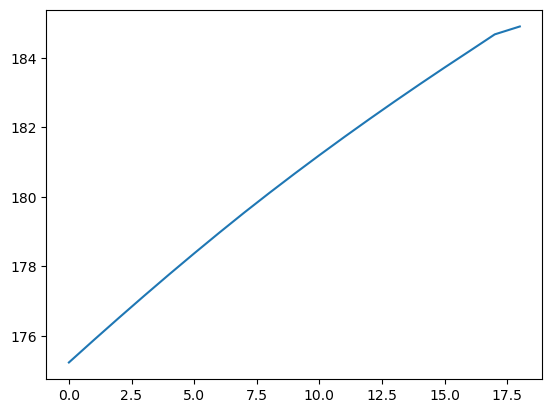

In [16]:
plt.plot(forecast[0,:])

In [17]:
N_it=forecast.shape[1]

In [18]:
delta_x=L/Nx

In [19]:
def findscalingquantities(pdot,t,v,delta_x,V_event=1e-2): 
    flag_event=False
    T1s=[] # this is the time of the start of events
    T2s=[] # this is the time of the end of events
    length_ruptures=[] # this is the length of the rupture
    pots=[] # integral of pdot over the event duration

    for i in range(v.shape[0]): # first dimension is time
        if np.max(v[i,:])>V_event and flag_event==False:
            start=i
            T1s.append(t[i,0])
            flag_event=True
            print(i)
        if np.max(v[i,:])<V_event and flag_event==True:
            end=i
            flag_event=False
            T2s.append(t[i,0])
            print(i)
            # check from start to end for all elements of v[start,:] to v[end,:] which elements had v >v_event in one line, from this you can find the event extent
            ruptured=np.where(v[start:end,:]>V_event,1,0)
            # find the locations at which at least there is one element that is ruptured
            ruptured=np.sum(ruptured,axis=0)
            ruptured=(ruptured>0)
            # summing number of ruptured elements
            num_ruptured_elements=np.sum(ruptured)
            # then the rupture length of this event is given by 
            length_rupture=num_ruptured_elements*delta_x
            length_ruptures.append(length_rupture)
            potency_of_event=integrate.cumtrapz(pdot[start:end],t[start:end,0])  
            print(potency_of_event[-1])  
            pots.append(potency_of_event[-1])
    return  T1s,T2s,length_ruptures,pots

In [20]:
def Gut(Mw,NpointsM=30):
    CumNumber=np.array([])
    c1=np.min(Mw)
    c2=np.max(Mw)-.0001 # To remove log10(0) error
    # print(c1)
    # print(c2)
    c=np.linspace(c1,c2,NpointsM)
    # print(c)
    for i in range(c.size):
        CumNumber=np.append(CumNumber,(sum(j > c[i] for j in Mw)))
    return c,CumNumber 

In [21]:
find_scaling=True
size_x=U_v.shape[0]


In [22]:
# V_ox_ROM=np.empty((N_it+1,size_x))
# t_ox_ROM=np.ones((N_it+1,size_x))
# vmax=[]
# U_ROM=U_v[:,0:N_m_v]
# for j in range(N_it):
#     V_snapshot = U_ROM @ (forecast[:N_m_v,j]) + q_bar_v.reshape(size_x,)
#     vmax.append(np.max(V_snapshot))
#     V_ox_ROM[j,:]=10**(V_snapshot)
#     t_ox_ROM[j,:]=time[j]*np.ones((1,size_x))
# if find_scaling:    
#     pdot=np.sum(V_ox_ROM,axis=1)*delta_x

#     T1s_ROM,T2s_ROM,length_ruptures_ROM,pots_ROM=findscalingquantities(pdot,t_ox_ROM,V_ox_ROM,delta_x,V_event=1e-3)
#     T1s_ROM=np.array(T1s_ROM)
#     T2s_ROM=np.array(T2s_ROM)
#     length_ruptures_ROM=np.array(length_ruptures_ROM)
#     pots_ROM=np.array(pots_ROM)
#     moment_ROM=mu*pots_ROM
#     log_10_moment_events_ROM=np.log10(moment_ROM)
#     mags_ROM,cumN_ROM=Gut(log_10_moment_events_ROM)
#     # if len(T2s_ROM) == len(T1s_ROM) - 1:
    
#     #     T1s_ROM = T1s_ROM[:-1]


In [23]:
T_final_ROM=time[-1]/cte.t_yr
print(T_final_ROM)

3.1688955410344087e-06


In [24]:
# # make a figure with
# plt.rcParams.update({
#     'font.family': 'serif',
#     'font.serif': ['Times New Roman'],
#     'text.usetex': True,  # If you want to use LaTeX for rendering text
# })
# fig, axs = plt.subplots(1, 3, figsize=(8, 3))

# plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman','font.size': 8})

# axs[0].plot(mags_ROM, cumN_ROM/T_final_ROM, '.',color='blue',label='ROM',marker='+')
# # axs[0].plot(mags, cumN/(number_to_load*T_final_run), '.', color='black',label="ROM")
# axs[0].set_yscale("log")
# # plotting in loglog scale the length of events in y axis and moment in x axis

# axs[1].plot(moment_ROM, T2s_ROM-T1s_ROM ,  '.', color='blue',label="ROM",marker="+")
# # axs[1].plot(moment_events, T2s_all-T1s_all ,  '.', color='black',label='PDE')

# axs[1].set_xscale('log')
# axs[1].set_yscale('log')
# axs[1].set_xlabel(r"$\mu \int_{t_{start}}^{t_{end}} \int_{A_{event}} v dz dt$")
# axs[1].set_ylabel(r"$t_{end}-t_{start}$ $(s)$")

# axs[2].plot(moment_ROM, length_ruptures_ROM ,  '.', color='blue',label="ROM",marker="+")
# # axs[2].plot(moment_events, length_ruptures_all , '.', color='black',label="PDE")

# axs[2].set_xscale('log')
# axs[2].set_yscale('log')
# axs[2].set_xlabel(r"$\mu \int_{t_{start}}^{t_{end}} \int_{A_{event}} v dz dt$")
# axs[2].set_ylabel(r"$A_{event}$ ($m^2$)")
# plt.tight_layout()
# plt.title("dissipate with: "+
# str(lambda_dissipation))
# #
# # plt.savefig("dissipate with: "+str(lambda_dissipation)+"rho"+str(rho)+".png")

so far, we have I have written the code to find the ROM and the scaling that I get is reasonable close to the original scaling



To do:
* find the model noise

In [25]:
# loading the model noise:
data_noise=np.load("/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/ML_EQ_Errors_N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+"version"+str(version)+".npz")
# find the mean and std of the error along the columns
Errors=data_noise['Errors'] # Errors is a matrix of size (N_m_v+N_m_theta,N_it)
mean_error=np.mean(Errors,axis=0)
cov_matrix = np.cov(Errors-mean_error, rowvar=False)
cov_matrix=cov_matrix*inflation
diag_cov_matrix=np.diag(cov_matrix)
# Create a diagonal matrix with the diagonal elements of the covariance matrix
print(diag_cov_matrix)
print(mean_error)
print(cov_matrix.shape)

[0.55098855 0.27171977 0.17654795 0.08932769 0.03753948 0.12318173
 0.03773844 0.02274779 0.0165304  0.0470226  0.03379696 0.02129202
 0.00934021 0.02172195 0.00878158 0.00596367 0.00301582 0.0136998
 0.00480487 0.00888292 0.29593523 0.23143733 0.13066449 0.07641905
 0.02822715 0.0833861  0.04793173 0.00894015 0.01519566 0.0168177
 0.01689157 0.01790479 0.01498624 0.00790753 0.00731855 0.00557153
 0.00724113 0.00372885 0.00304018 0.00309683]
[-5.92018016e-03  2.99556260e-03 -4.47690080e-03  2.69892099e-03
 -2.14500223e-04 -1.14791892e-03  1.71699851e-03 -1.12158897e-03
 -8.34821189e-04  2.08817864e-03 -1.57633172e-03  1.24389320e-03
  1.30249988e-04 -8.52612893e-04  2.03290893e-04  1.21356814e-04
 -3.68453257e-04 -4.62582555e-04  5.85293030e-04  8.50010230e-04
 -3.27336465e-03 -2.85065200e-03 -4.06763045e-03 -2.99049909e-03
 -1.04069837e-03 -1.41527014e-03 -2.28649931e-03  3.00665225e-04
  6.03144414e-04 -4.59634918e-04 -1.00346910e-03 -1.16575039e-03
  9.36718207e-04  3.43861399e-04 -

# Observation model

In [26]:
U_ROM=U_v[:,0:N_m_v]
vpl=50e-3/cte_eq.t_yr     # Plate velocity
Obs_nonlinear_params=[U_ROM,q_bar_v,N_m_v,size_x,sigma_x,vpl]

def Obs_operator_linear(alpha):

    return alpha[:N_m_v].reshape(-1,1)

def Obs_operator_nonlinear(alpha,Obs_nonlinear_params):
    # this function takes alpha as input, finds slip rate from alpha, applies the gaussian kernel, then project the log10 of the slip rate again, and then finds observation. All of the steps are written in the paper so dont worry about it.
    U_ROM=Obs_nonlinear_params[0]
    q_bar_v=Obs_nonlinear_params[1]
    N_m_v=Obs_nonlinear_params[2]
    size_x=Obs_nonlinear_params[3]
    sigma_x=Obs_nonlinear_params[4]
    vpl=Obs_nonlinear_params[5]
    # finding v from alphas:
    

    V_snapshot1 = U_ROM @ (alpha[:N_m_v]) + q_bar_v.reshape(size_x,)
    V_snapshot2 = 10**(V_snapshot1)
    # Apply gaussian filter here:
    V_snapshot4 = scipy.ndimage.gaussian_filter(V_snapshot2, sigma=(sigma_x),mode='constant',cval=(vpl))
    
    V_snapshot_back1=np.log10(V_snapshot4)
    V_snapshot_back2=V_snapshot_back1.reshape(size_x,)
    alpha_v=U_ROM.T @ (V_snapshot_back2-q_bar_v.reshape(size_x,))

    return alpha_v.reshape(-1,1)


In [27]:
# This piece of code is written to load a simuulation in data the output of this block is V_ox,theta_ox,t_ox. We project them onto the first POD modes. and then extract the time series and name them A. We also remove some of the data to remove the transient response in it.

## defining the quantities for loading the data:

T_final_run = 350 # each initial condition is simulated for 250 years
Nt=5     # it is recorded every Nt time stes
N_m_v=20 # number of modes that they have considered
N_m_theta=20 # number of modes that they have considered
coeff=1 # How the inital conditions are from the chaotic attractor
number=101 # Which one do you want to load
N_m_load=30
X_full=np.empty((1,N_m_load*2))
L=240e3
filter_ratio = 0.2
## 
# loading raw data
data_dir='/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/SampleSimulation_Tf_2D'+str(T_final_run)+"Nt="+str(cte_eq.Ntout)+"N_m"+str(N_m_load)+"coeff"+str(coeff)+"number"+str(number)+".npz"
data_smaple=np.load(data_dir)
V_ox=data_smaple['array1']
theta_ox=data_smaple['array2']
t_ox=data_smaple['array3']

# preprocessing 
t=t_ox[:,0].reshape(-1,1)
V_ox=np.log10(V_ox)
theta_ox=np.log10(theta_ox)
A_v,P_v=find_Aisv2_onlyv(U_v,V_ox,q_bar_v,N_m_load) # you dont need P in general, but I need it to check if I do everything correctly
A_theta,P_theta=find_Aisv2_onlyv(U_theta,theta_ox,q_bar_theta,N_m_load)
# concatenating the two arrays
A=np.concatenate((A_v,A_theta),axis=1)
Start_index=int(V_ox.shape[0]*filter_ratio)
A_filtered=A[Start_index:,:] # with removig the first 20 percent of the data to remove the transient
time_nonuniform=t[Start_index:,:]

index_delete=np.array([])
if N_m_v<N_m_load:
    index_delete=np.append(index_delete,np.arange(N_m_v,N_m_load))
if N_m_theta<N_m_load:
    index_delete=np.append(index_delete,np.arange(N_m_load+N_m_theta,2*N_m_load))

index_delete = index_delete.astype(int) # Convert the array elements to integers
A_filtered=np.delete(A_filtered,index_delete,axis=1)
t_0=time_nonuniform[0]
t_end=time_nonuniform[-1]



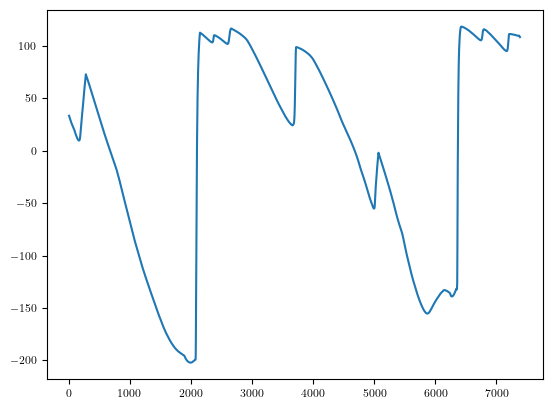

In [28]:
plt.plot(A_filtered[:,0])

In [29]:
A_filtered.shape

(7388, 40)

Text(0.5, 1.0, 'Low resolution data vs high resolution')

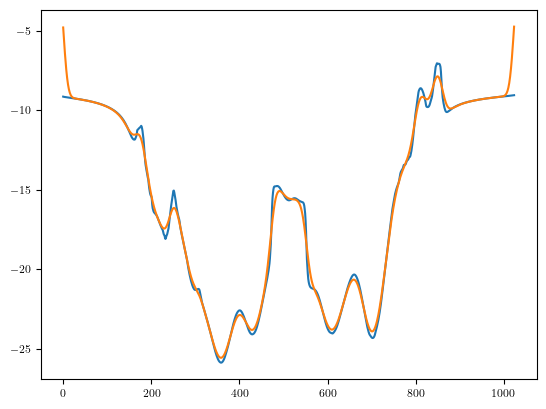

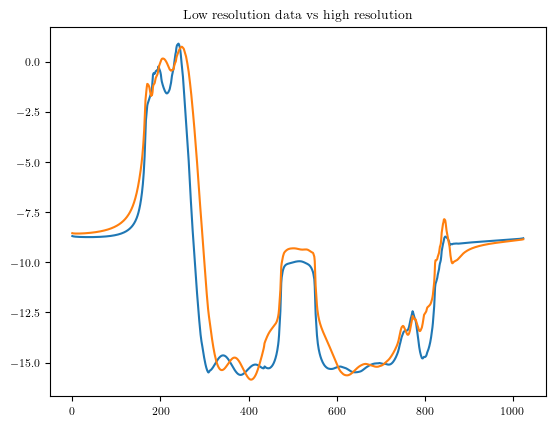

In [30]:
# This is a code to see the effect of resolution reduction
# check point1
# Study the effect of low resolution
plt.figure()
V_snapshot4 = scipy.ndimage.gaussian_filter(V_ox[0,:], sigma=(sigma_x),mode='constant',cval=(vpl))
plt.plot(V_ox[0,:])
plt.plot(V_snapshot4)
# checkpoint 2
# see the effect of function
index=3000
V_snapshot_clean=(U_ROM @ (A_filtered[index,:N_m_v])).reshape(size_x,) + q_bar_v.reshape(size_x,)
alpha_output_test=Obs_operator_nonlinear(A_filtered[index,:],Obs_nonlinear_params)
V_snapshot1 = (U_ROM @ (alpha_output_test)).reshape(size_x,) + q_bar_v.reshape(size_x,)
plt.figure()
plt.plot(V_snapshot_clean)
plt.plot(V_snapshot1)
plt.title("Low resolution data vs high resolution")

In [31]:
# make uniform time steps with dt strating from t_0
N_data=300000 # this was 5000 for SSEs and it took a long time.

time_uniform=np.linspace(t_0,t_0+N_data*dt,N_data)
time_uniform.shape
X_uniform=np.empty((N_data,A_filtered.shape[1]))
y_obs=np.empty((N_data,N_m_v))

for i in range(A_filtered.shape[1]):
    X_uniform[:,i]=np.interp(time_uniform,time_nonuniform[:,0],A_filtered[:,i]).reshape(-1)

if Obs_linear==1:
    y_obs=X_uniform[:,:N_m_v]+eta_call(Gamma,gamma_ratio,N_data).T
else:
    for i in range(N_data):
        y_obs[i,:]=Obs_operator_nonlinear(X_uniform[i,:],Obs_nonlinear_params).reshape(-1)+eta_call(Gamma,gamma_ratio,1).reshape(-1)
y_obs=y_obs.T

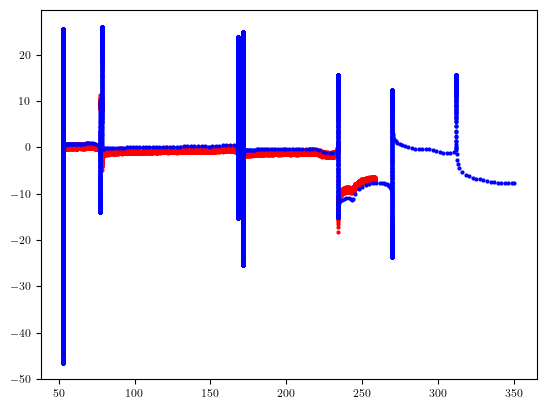

In [32]:
# Checking interpolation
index_component_to_show=7
plt.plot(time_uniform/24/3600/365,y_obs[index_component_to_show,:],label='Obs Uniform',color='r',linestyle='None',marker='o',markersize=2)
# plot with no line only with marker:
plt.plot(time_nonuniform/24/3600/365,A_filtered[:,index_component_to_show],label='Non-uniform',color='b',linestyle='None',marker='o',markersize=2)
# plt.xlim([150,180])


In [33]:
H=np.append(np.eye(N_m_v,N_m_v),np.zeros((N_m_v,N_m_theta)),axis=1)

In [34]:
np.random.seed(0)

In [35]:
# applying EnKF,
# The forward model is f and the observation operator is Obs_operator_linear
# The observation operator is linear and it is the first N_m_v components of the state
# start from m random initial conditions:
m=80

N_t=100 # number of time units
N_m=N_m_v+N_m_theta
alpha_f=np.empty((N_m,m,N_t))
alpha_a=np.empty((N_m,m,N_t))
# specifying random seed
np.random.seed(1)
alpha_a[:,:,0]=xi_call(N_m,Lambda,m) # initial conditions, every column is an ensemble member, The first analysis is the initial condition and is randomly selected based on the PDF of the chaotic attractor
Innovations=np.empty((N_m_v,m,N_t))
Obs_an=np.empty((N_m_v,m,N_t))      # Observation anomaly 
Obs=np.empty((N_m_v,m,N_t))         # Observation
for k in range(N_t-1):
    # print(k)
    # forecast step:
    for i in range(m):
        print(i)
        alpha_f[:,i,k+1]=f(alpha_a[:,i,k],dt,params_f)[0][:,-1] + xi_call(N_m,cov_matrix,1).reshape(N_m,) # this is the forecast ,[0] is to not consider time and -1 is to take the last time step
    # finding Kalman gain:
    alpha_bar=np.mean(alpha_f[:,:,k+1],axis=1).reshape(N_m,1) # this is the mean of the forecast with adding one dimension
    # anomaly matrix:
    A_f=(alpha_f[:,:,k+1]-alpha_bar)/np.sqrt(m-1)
    # covariance matrix of the forecast:
    P_f=np.dot(A_f,A_f.T)
    # Kalman gain:
    if Obs_linear==1:
        K=scipy.linalg.solve(np.dot(H,np.dot(P_f,H.T))+gamma_ratio*Gamma,np.dot(H,P_f)).T
        # analysis step:
        for i in range(m):
            alpha_a[:,i,k+1]=alpha_f[:,i,k+1]+np.matmul(K,y_obs[:,k+1].reshape(-1,1)-Obs_operator_linear(alpha_f[:,i,k+1])).reshape(N_m,)
            Innovations[:,i,k+1]=y_obs[:,k+1]-Obs_operator_linear(alpha_f[:,i,k+1]).reshape(-1)
    else:
        # finding the observation anomaly matrix:
        for i in range(m):
            Obs[:,i,k+1]=Obs_operator_nonlinear(alpha_f[:,i,k+1],Obs_nonlinear_params).reshape(N_m_v,) # h(\alpha^{f,i}) in the paper
        
        etas=eta_call(Gamma,gamma_ratio,m) # This function makes noise with shape N_m_v* m, each column is one noise for one ensemble member
        mean_obs=np.mean(Obs[:,:,k+1],axis=1) # this is the mean of the observation (denoted by \bar z in Jeff's paper) or \bar y^f in my paper, has the shape (N_m_v,)
        mean_eta=np.mean(etas,axis=1) # this is the mean of the observation noise (denoted by \bar v in Jeff's paper) or \bar \eta in my paper , has the shape (N_m_v,)

        Obs_an[:,:,k+1]=(Obs[:,:,k+1]-mean_obs[:,np.newaxis]-etas+mean_eta[:,np.newaxis])/np.sqrt(m-1) # This is matrix Z i Jeff's paper or Y in my paper
        # Finding Kalman gain:
        K=scipy.linalg.solve(Obs_an[:,:,k+1]@Obs_an[:,:,k+1].T,Obs_an[:,:,k+1]@A_f.T).T       
        # analysis step:
        for i in range(m):
            alpha_a[:,i,k+1]=alpha_f[:,i,k+1]+np.matmul(K,y_obs[:,k+1]-Obs[:,i,k+1])     
            Innovations[:,i,k+1]=y_obs[:,k+1]-Obs[:,i,k+1]
            
        

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [ ]:
time=np.linspace(0,N_t*dt,N_t)

In [ ]:
mean_a=np.mean(alpha_a,axis=1)


In [ ]:
for i in range(m):
    plt.plot(time/3600/24,alpha_a[0,i,:],color='b',alpha=0.1)
plt.plot(time/3600/24,y_obs[0,:N_t],label='Observation',color='r')
plt.xlim([5,100])
plt.ylim([0,50])

In [ ]:
# plotting the time series of innovations
for i in range(m):
    plt.plot(time/3600/24,Innovations[0,i,:],color='b',alpha=0.1)
plt.xlim([5,100])
plt.ylim([-50,50])

In [ ]:
# Postprocessing and plotting the the behavior of the EnKF
# One natural figure to think of is plotting the first four dims of observation and the first four dims of the EnKF for all members
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': True,  # If you want to use LaTeX for rendering text
})

fig, axs = plt.subplots(10, 1, figsize=(3.8, 14))
# adjust the font size for anything in this figure

# Flatten the axs array so that we can iterate over it easily
axs = axs.flatten()
plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman','font.size': 8})

# Plot the KDE plot for each column of X_full
for i in range(10):
    for j in range(m-1):
        axs[i].plot(time/3600/24,alpha_a[i,j,:],color='b',alpha=0.1)
    axs[i].plot(time/3600/24,alpha_a[i,-1,:],color='b',alpha=0.1,label='Ensemble Members')
    axs[i].plot(time/3600/24,y_obs[i,:N_t],label='Observation',color='r')
    axs[i].plot(time/3600/24,X_uniform[:N_t,i],label='True State',color='k')
    axs[i].set_title(r'$\alpha^v_{{{}}}$'.format(i+1))
    axs[i].set_xlim(left=5)
    axs[i].legend(ncol=2)
    axs[i].set_xlabel('Time (days)')
    leg = axs[i].legend()
    for lh in leg.legendHandles:
          lh.set_alpha(1)
    
# Adjust layout and show plot
plt.tight_layout()
plt.show()
# save the figure in the central directory
#fig.savefig("/central/groups/astuart/hkaveh/Figs/ROM/draft_EnKF_vel"+"4.pdf", bbox_inches='tight')


In [ ]:
# Postprocessing and plotting the the behavior of the EnKF
# One natural figure to think of is plotting the first four dims of observation and the first four dims of the EnKF for all members
theta_data=X_uniform[:,N_m_v:].T
fig, axs = plt.subplots(10, 1, figsize=(3.8, 14))

# Flatten the axs array so that we can iterate over it easily
axs = axs.flatten()

# Plot the KDE plot for each column of X_full
for i in range(10):
    for j in range(m-1):
        axs[i].plot(time/3600/24,alpha_a[i+N_m_v,j,:],color='b',alpha=0.1)
    axs[i].plot(time/3600/24,alpha_a[i+N_m_v,-1,:],color='b',alpha=0.1,label='Ensemble Members')
    axs[i].plot(time/3600/24,theta_data[i,:N_t],label='Non-Observable state',color='r')
    axs[i].set_title(r'$\alpha^\theta_{{{}}}$'.format(i+1))
    axs[i].set_xlim(left=5)
    axs[i].legend(ncol=2)
    axs[i].set_xlabel('Time (days)')
    leg = axs[i].legend()
    for lh in leg.legendHandles:
          lh.set_alpha(1)

# Adjust layout and show plot
plt.tight_layout()
plt.show()
# save the figure in the central directory
#fig.savefig("/central/groups/astuart/hkaveh/Figs/ROM/draft_EnKF_theta"+"4.pdf", bbox_inches='tight')

 
